# Settings and libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
from __future__ import division
from fastai.vision import *
from fastai.vision.all import *
from fastai.callbacks import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor
import pretrainedmodels

ModuleNotFoundError: No module named 'fastai.vision.all'

# Load data

In [5]:
wine = load_wine()

In [6]:
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, ..., 5.640e+00, 1.040e+00, 3.920e+00, 1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, ..., 4.380e+00, 1.050e+00, 3.400e+00, 1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, ..., 5.680e+00, 1.030e+00, 3.170e+00, 1.185e+03],
        [1.437e+01, 1.950e+00, 2.500e+00, 1.680e+01, ..., 7.800e+00, 8.600e-01, 3.450e+00, 1.480e+03],
        ...,
        [1.340e+01, 3.910e+00, 2.480e+00, 2.300e+01, ..., 7.300e+00, 7.000e-01, 1.560e+00, 7.500e+02],
        [1.327e+01, 4.280e+00, 2.260e+00, 2.000e+01, ..., 1.020e+01, 5.900e-01, 1.560e+00, 8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, 2.000e+01, ..., 9.300e+00, 6.000e-01, 1.620e+00, 8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, 2.450e+01, ..., 9.200e+00, 6.100e-01, 1.600e+00, 5.600e+02]]),
 'target': array([0, 0, 0, 0, ..., 2, 2, 2, 2]),
 'frame': None,
 'target_names': array(['class_0', 'class_1', 'class_2'], dtype='<U7'),
 'DESCR': '.. _w

## Get data into a dataframe

In [7]:
df = pd.DataFrame(data=np.c_[wine['data'], wine['target']].astype('float32'),
                  columns=wine['feature_names'] + ['target'])

In [8]:
df.target = df.target.values.astype(int)

In [9]:
print(df.shape)

(178, 14)


In [10]:
features = wine['feature_names']

In [11]:
features

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

# Transform data into image format

I had trouble loading some standard fonts, so I ended up browsing my /usr/share/fonts/truetype to see what´s available on my machine to use for projecting features into drawn numbers in a font

In [21]:
font = ImageFont.truetype('NotoMono-Regular.ttf', 13)

In [22]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    for i, f in enumerate(event):
        ImageDraw.Draw(img).text((((1/3)+(i%2))*size//2,(size//11)+((i//2)*1.7*size//len(event))), f'{f:.1f}', fill=(255,255,255), font=font)
    return img

CPU times: user 4.01 ms, sys: 0 ns, total: 4.01 ms
Wall time: 3.4 ms


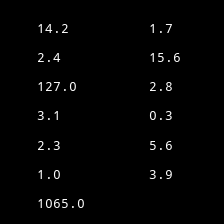

In [23]:
%%time
event2img(df[features].values[0])

## Transform every example from the training set

In [50]:
path = Path()

In [55]:
sys.path.append('images')

In [86]:
IMG_PATH = 'images/wine'

In [73]:
os.mkdir(IMG_PATH)

In [88]:
path = Path(IMG_PATH)

In [90]:
for mode in ['train']: 
    os.makedirs(path/mode, exist_ok=True)

In [92]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [91]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=path/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[features].values, df.index.values)

In [93]:
%%time
proc_sample(df, 'train')

CPU times: user 77.4 ms, sys: 196 ms, total: 274 ms
Wall time: 450 ms


In [94]:
df.reset_index(inplace=True)
df.rename(columns={'index':'image_name'}, inplace=True)
df.to_csv(path/'train.csv', index=False)

In [120]:
df

,image_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,173,13.71,5.65,2.45,20.500000,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,174,13.40,3.91,2.48,23.000000,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,175,13.27,4.28,2.26,20.000000,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,176,13.17,2.59,2.37,20.000000,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


# Baseline classifier

In [95]:
train, val = train_test_split(df.copy(), stratify=df.target, test_size=0.2, random_state=0)

In [99]:
rf = RandomForestClassifier(n_jobs = -1, n_estimators=40 )

In [100]:
rf.fit(train[features], train.target)

RandomForestClassifier(n_estimators=40, n_jobs=-1)

In [101]:
accuracy_score(val.target, rf.predict(val[features]))

1.0

# Super tml

## Load image data

In [106]:
np.random.seed(0)

In [107]:
data = ImageDataBunch.from_df(df=df, label_col='target', fn_col='image_name',
                              bs=16, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH, folder='train', suffix='.png').normalize(imagenet_stats)

/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [108]:
data

ImageDataBunch;

Train: LabelList (143 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: images/wine;

Valid: LabelList (35 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,2,1,0,1
Path: images/wine;

Test: None

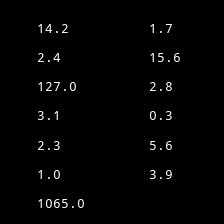

In [109]:
data.train_ds[0][0]

## Model training

In [110]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, lin_ftrs=[], bn_final=False, ps=[0])

In [111]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

/anaconda/envs/azureml_py36_tensorflow/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


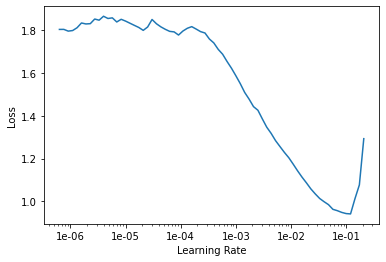

In [112]:
learn.lr_find()
learn.recorder.plot()

In [113]:
learn.save('stage-1')

In [114]:
learn.unfreeze()

In [115]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


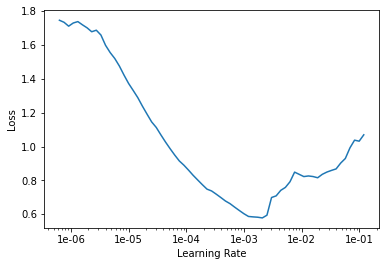

In [116]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best', mode='max')])

epoch,train_loss,valid_loss,accuracy,time
0,1.841570,1.763332,0.371429,00:18
1,1.480251,1.933974,0.400000,00:19
2,1.093036,1.423159,0.314286,00:19
3,0.800160,1.300293,0.371429,00:18
4,0.599607,1.190197,0.514286,00:19
5,0.466115,0.757819,0.685714,00:18
6,0.371889,0.699678,0.685714,00:18
7,0.304117,0.666536,0.742857,00:18
8,0.248408,0.530306,0.771429,00:19
9,0.206894,0.438841,0.857143,00:18


Better model found at epoch 0 with accuracy value: 0.37142857909202576.
Better model found at epoch 1 with accuracy value: 0.4000000059604645.
Better model found at epoch 4 with accuracy value: 0.5142857432365417.
Better model found at epoch 5 with accuracy value: 0.6857143044471741.
Better model found at epoch 7 with accuracy value: 0.7428571581840515.
Better model found at epoch 8 with accuracy value: 0.7714285850524902.
Better model found at epoch 9 with accuracy value: 0.8571428656578064.


In [118]:
learn.load('best');

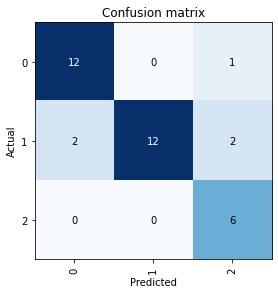

In [119]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [5]:
!pip install fastai

In [4]:
import fastai
print(fastai.__version__)

1.0.61


In [127]:
print(fastai.__ version __ )

SyntaxError: invalid syntax (<ipython-input-127-66509cf407e5>, line 1)

In [125]:
most_unsure = DatasetFormatter.from_most_unsure(learn)
wgt = PredictionsCorrector(*most_unsure)

NameError: name 'DatasetFormatter' is not defined